In [ ]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data
import torchvision
from torchvision import datasets, transforms;
import matplotlib.pyplot as plt
import numpy as np


# Load training dataset and test dataset
train_data = datasets.MNIST('./datasets', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST('./datasets', train=False, download=True, transform=transforms.ToTensor())

# 한번에 batch_size 만큼의 데이터만 불러오게 하고, 순서를 섞어서 불러오게 해줌. 
batch_size = 12
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

# Define MLP neural network model
# class MLP(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.in_dim = 28 * 28 # input dimension
#         self.out_dim = 10 # output dimension (class 0~9)
#         # 층 정의
#         self.fc1 = nn.Linear(self.in_dim, 512)
#         self.fc2 = nn.Linear(512, 256)
#         self.fc3 = nn.Linear(256, 128)
#         self.fc4 = nn.Linear(128, 64)
#         self.fc5 = nn.Linear(64, self.out_dim)
# 
#     def forward(self, x):
#         # Forward pass through each layer with ReLU activation function
#         x = F.relu(self.fc1(x.view(-1, self.in_dim)))
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
#         x = F.relu(self.fc4(x))
#         x = self.fc5(x) # 
#         return x
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.in_dim = 28 * 28 # input dimension
        self.out_dim = 10 # output dimension (class 0~9)
        layers = [nn.Linear(self.in_dim, 512),nn.ReLU()]
        for _ in range(3):
            layers.append(nn.Linear(512, 512))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(512, self.out_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x.view(-1, self.in_dim))


model = MLP()

criterion = nn.CrossEntropyLoss() # Loss function
optimizer = optim.SGD(model.parameters(), lr=0.01) # optimizer  
for epoch in range(5):
    running_loss = 0.0
    # batch iteration, batch_size가 12이고, MNIST 데이터는 6만개이므로 5000번의 iteration
    for i, data in enumerate(train_loader, 0):
        inputs, label = data
        model.zero_grad() # 이전 batch iteration 에서 기울기 값이 누적 되지 않기 위해 기울기를 초기화
        outputs = model(inputs) 
        loss = criterion(outputs, label) # loss 계산
        loss.backward() # 기울기 계산
        optimizer.step() # 파라미터 업데이트
        running_loss += loss.item()
        if (i + 1) % 1000 == 0:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            
#  test dataset을 이용하여 일부 결과 확인
images, labels = next(iter(test_loader))
plt.imshow(np.transpose(torchvision.utils.make_grid(images, nrow=batch_size), (1, 2, 0)))
print('GroundTruth')
print(" " + ' '.join('%3s' % label.item() for label in labels))
outputs = model(images)
_, predicted = torch.max(outputs, 1)
print("Prediction")
print(" " + ' '.join('%3s' % label.item() for label in predicted))

Size: 4.559 MB
9718/10000
Accuracy: 0.9718


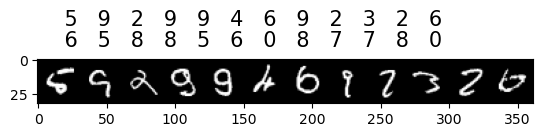

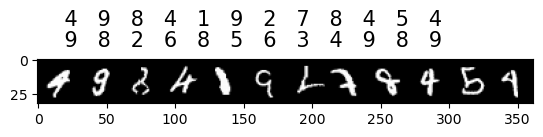

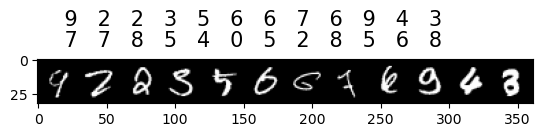

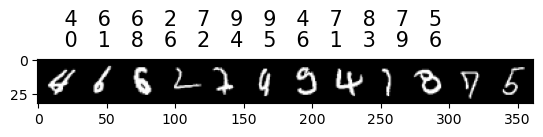

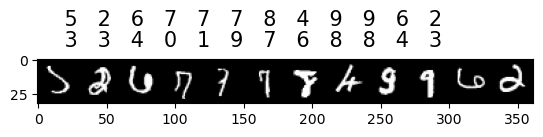

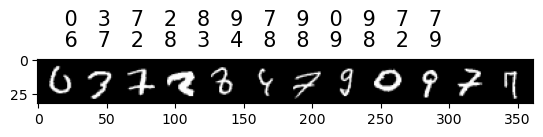

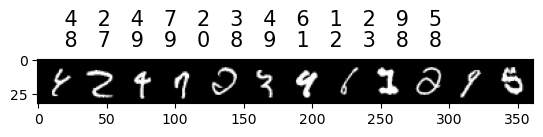

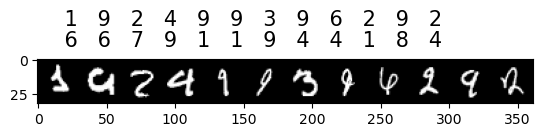

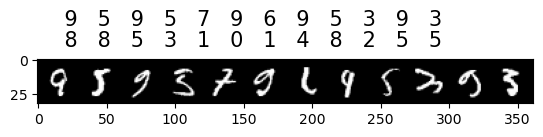

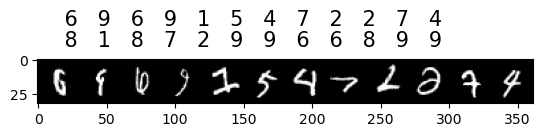

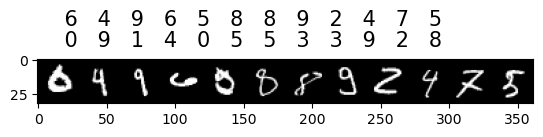

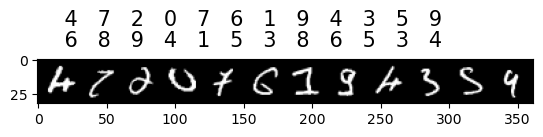

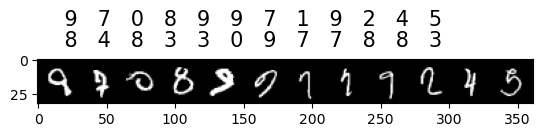

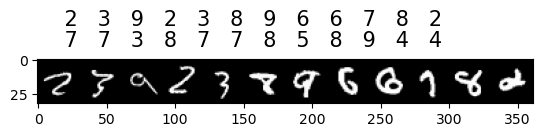

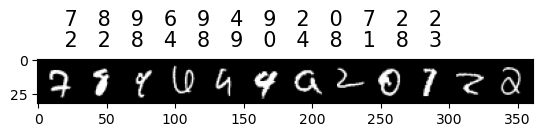

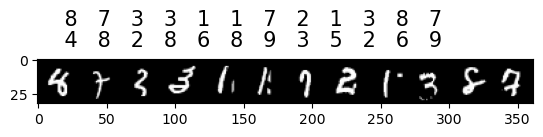

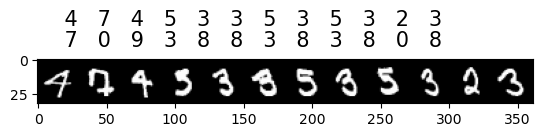

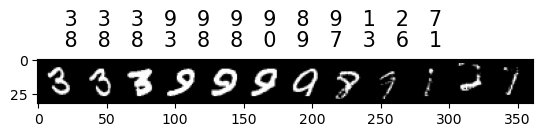

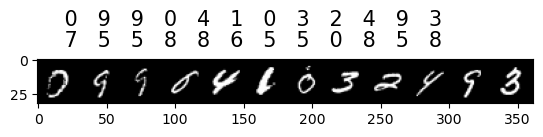

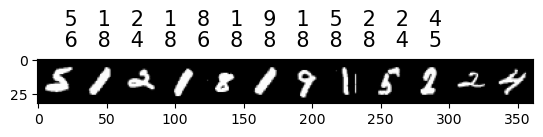

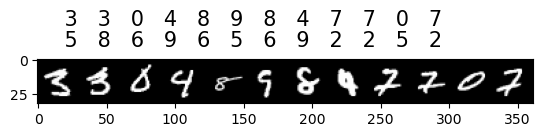

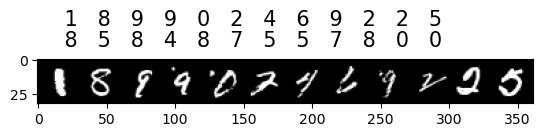

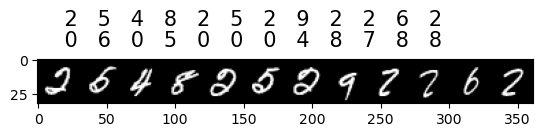

In [3]:
param_size = 0
buffer_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
    
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('Size: {:.3f} MB'.format(size_all_mb))

n_predict = 0
n_correct = 0
wrong = []
expected = []
results = []
for data in test_loader:
    inputs, labels = data
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    n_predict += len(predicted)
    for label, pred, input in zip(labels, predicted, inputs):
        if label != pred:
            wrong.append(input)
            expected.append(pred)
            results.append(label)
        else:
            n_correct += 1
print("{}/{}".format(n_correct, n_predict))
print("Accuracy: {}".format((n_correct / n_predict)))

for i in range(len(wrong) // 12):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.text(0, -10, "  " + ' '.join('%3s' % label.item() for label in expected[i * 12:i * 12 + 12]), fontsize=15)
    ax.text(0, -25, "  " + ' '.join('%3s' % label.item() for label in results[i * 12:i * 12 + 12]), fontsize=15)
    plt.imshow(np.transpose(torchvision.utils.make_grid(wrong[i * 12:i * 12 + 12], nrow=batch_size), (1, 2, 0)))
    plt.show()